# Create a 1D signal GAN for voice recorded signals
## Use a very basic GAN architecture that works with a single dimension (1D array)

In [42]:
import sounddevice as sd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Audio
from scipy.io.wavfile import write
import os
import torch.nn.functional as F


# Lets setup some basic configurations

In [43]:
sample_rate = 44100
duration = 1  # 2 seconds
signal_length = sample_rate * duration

## Define the Generator class

In [44]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.Linear(64, output_dim),
            nn.Tanh()  # Output in the range [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

## Define the Discriminator class

In [45]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, x):
        return self.model(x)

## Custom dataset class for voice signals

In [46]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, sample_rate=22050, duration=2):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.duration = duration
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]  # Only .npy files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        # Load numpy array
        waveform = np.load(file_path)
        # Ensure the audio is 2 seconds long
        target_length = self.sample_rate * self.duration
        if waveform.size < target_length:
            # Pad the waveform if it's shorter than 2 seconds
            waveform = np.pad(waveform, (0, target_length - waveform.size), mode='constant')
        else:
            # Trim the waveform if it's longer than duration
            waveform = waveform[:target_length]
        waveform = waveform.astype(np.float32)
        waveform = (waveform - min(waveform)) / (max(waveform) - min(waveform)) * 2 - 1 
        waveform = waveform/np.max(waveform)
        return torch.tensor(waveform,dtype=torch.float32)  # Convert to tensor


## Prepare the dataset for training the GAN

In [47]:
# Create the dataset and dataloader
batch_size = 128
dataset = AudioDataset('audioMNIST/', sample_rate, duration)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(dataset))

30000


tensor([-0.0375, -0.0375, -0.0406,  ..., -0.0145, -0.0145, -0.0145])


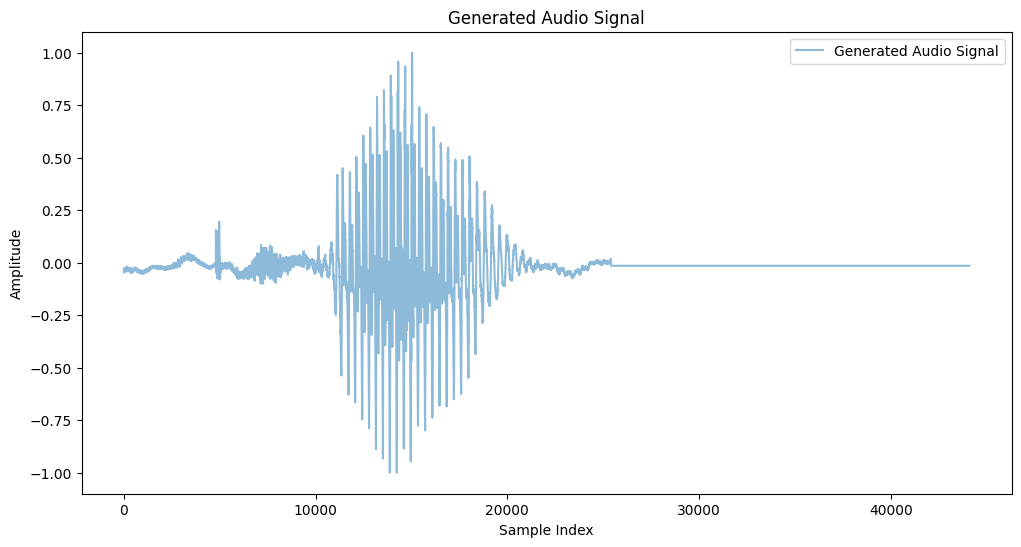

In [48]:
# plot the signal 
for batch in dataloader:
    # Plot the generated audio signal
    plt.figure(figsize=(12, 6))
    print(batch[0])
    plt.plot(batch[0], label='Generated Audio Signal', alpha=0.5)
    plt.title('Generated Audio Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    break

## Initialize the generator and discriminator

In [49]:
# Set up the GAN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the models
hidden_dim = 128
learning_rate=0.0002
generator = Generator(hidden_dim,signal_length)
discriminator = Discriminator(signal_length)

## Define the loss function and optimizers

In [50]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.SGD(generator.parameters(), lr=learning_rate, momentum=0.0715)
d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=learning_rate, momentum=0.00515)
g_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(g_optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
d_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(d_optimizer, T_0=10, T_mult=1, eta_min=0.0001, last_epoch=-1)
num_epochs = 10


## Training the GAN

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for batch in dataloader: # batch is (batch_size, time_steps, features)
        # Generate fake signal
        noise = torch.randn(batch.shape[0], hidden_dim) 
        generated_signal = generator(noise)

        # Create labels
        real_labels = torch.ones(batch.size(0), 1)
        fake_labels = torch.zeros(batch.size(0), 1)

        # Train the discriminator
        discriminator.zero_grad()
        real_output = discriminator(batch.squeeze(-1))  # Use the real audio batch
        real_loss = criterion(real_output, real_labels)
        fake_output = discriminator(generated_signal.detach())  # Use the generated signal
        fake_loss = criterion(fake_output, fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        d_scheduler.step()

        # Train the generator
        generator.zero_grad()
        fake_output = discriminator(generated_signal.detach())  # Use the generated signal
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()
        g_scheduler.step()

    #if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}')

Epoch: 0, Generator Loss: 0.7234360575675964, Discriminator Loss: 1.3903439044952393
Epoch: 0, Generator Loss: 0.7313109636306763, Discriminator Loss: 1.3852732181549072
Epoch: 0, Generator Loss: 0.7287445068359375, Discriminator Loss: 1.3877942562103271
Epoch: 0, Generator Loss: 0.7290424704551697, Discriminator Loss: 1.390787124633789
Epoch: 0, Generator Loss: 0.7342129945755005, Discriminator Loss: 1.3804699182510376
Epoch: 0, Generator Loss: 0.72819983959198, Discriminator Loss: 1.3891762495040894
Epoch: 0, Generator Loss: 0.7311806678771973, Discriminator Loss: 1.3847674131393433
Epoch: 0, Generator Loss: 0.733609139919281, Discriminator Loss: 1.3842384815216064
Epoch: 0, Generator Loss: 0.73260498046875, Discriminator Loss: 1.3850631713867188
Epoch: 0, Generator Loss: 0.733310341835022, Discriminator Loss: 1.3804922103881836
Epoch: 0, Generator Loss: 0.7350808382034302, Discriminator Loss: 1.3810439109802246
Epoch: 0, Generator Loss: 0.7343372702598572, Discriminator Loss: 1.3790

## Generate new signals after training

In [ ]:
# Set the generator to evaluation mode
generator.eval()
# Generate and visualize a sample output
with torch.no_grad():
    sample_noise = torch.randn(1,hidden_dim)  # Adjust noise shape
    generated_audio = generator(sample_noise).detach().numpy().flatten()
print(generated_audio.shape)
# Plot the generated audio signal
plt.figure(figsize=(12, 6))
plt.plot(generated_audio, label='Generated Audio Signal', alpha=0.5)
plt.title('Generated Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# saving the output
np.save('generated/generated.npy', generated_audio)
from scipy.io.wavfile import write

# Assuming the array values are in the range of int16 for WAV format
# Scale the array if necessary
generated_audio = np.int16(generated_audio / np.max(np.abs(generated_audio)) * 32767)

# Save the array as a WAV file
write('generated/generated.wav', sample_rate, generated_audio) 